In [39]:
# Import library
import shutil, os
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += ";C:\\hadoop\\bin"

print("HADOOP_HOME =", os.environ.get("HADOOP_HOME"))

# Tes winutils path
os.system("where winutils")
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd


# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Midterm Project") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark


HADOOP_HOME = C:\hadoop


In [40]:
# ============================================================================
# 1. DATA LOADING & INITIAL EXPLORATION
# ============================================================================
print("\n1. LOADING AND EXPLORING THE DATASET")
print("-" * 80)

# Path dataset
data_path = "../data/raw/medical_insurance.csv"

# Load dataset ke dalam Spark DataFrame
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Ukuran data dan contoh isi
print(f"Jumlah baris: {df.count()}, Jumlah kolom: {len(df.columns)}")
df.show(5)
df.printSchema()


1. LOADING AND EXPLORING THE DATASET
--------------------------------------------------------------------------------
Jumlah baris: 100000, Jumlah kolom: 54
+---------+---+------+-------+-----------+-------+------------+--------------+-----------------+--------------+----------+----+------+------------+----------------+--------------------------+---------------------------+----------------+-----------+------------+-----+-----+---------+------------+----------+-----+-----------------+------------------------+----------------+----------+-------------------+--------------+---------------+------------+----------------+-----------------+-------------+------------+--------+------+----+----------------------+--------------+--------------+-------------+---------+-------------+------------------+------------------+-----------------+------------------+--------------+------------+-------------------+
|person_id|age|   sex| region|urban_rural| income|   education|marital_status|employment_status|

In [41]:
print(f"\nStatistik:")
df.describe().toPandas().style.set_table_attributes("style='display:inline'")


Statistik:


,summary,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,hba1c,plan_type,network_tier,deductible,copay,policy_term_years,policy_changes_last_2yrs,provider_quality,risk_score,annual_medical_cost,annual_premium,monthly_premium,claims_count,avg_claim_amount,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
1,mean,50000.5,47.5215,None,None,None,49873.905,None,None,None,2.4309,0.89838,26.990511999999992,None,None,1.92765,0.09364,0.37335,1.23632,117.80897,73.60477,119.97506500000004,5.605967799999988,None,None,1226.725,19.5204,5.51776,0.05069,3.598920099999994,0.5198492950000019,3009.451907000008,582.3200397000005,48.52666820000009,1.62178,656.5120837000012,1377.8788266999993,0.72472,0.20345,0.08593,0.05887,0.03595,0.05117,0.02151,0.01462,0.01477,0.10831,0.13014,0.50853,0.15869,0.50839,0.50933,0.50914,0.36781,0.1697
2,stddev,28867.65779668776,15.988752113656073,None,None,None,46800.21412719603,None,None,None,1.0751263874389323,0.9506536767004745,4.994882507764189,None,None,1.7377300350045026,0.3048482896865212,1.3730107898652115,1.2093582939207181,15.369187345409532,8.900924418938464,30.262085719330294,0.845995622003497,None,None,1019.6193753610736,10.286254999290035,2.8688267434735084,0.22459080192715625,0.5940524503771766,0.2506687217065255,3127.4628223865643,399.58372199751375,33.29863999101709,2.029820394347329,1072.6600483424254,2305.464686671332,0.8055230662582553,0.4025664145171343,0.2802620569542114,0.23538240620057277,0.18616644187242964,0.22034544837859948,0.14507767014707584,0.12002666230465892,0.12063164021070988,0.31077308393600794,0.3364590798999553,0.7497552003344853,0.4635618974811539,0.7472183022731125,0.75363030106698,0.7504545903790069,0.4822117057696669,0.37537090861332156
3,min,1,0,Female,Central,Rural,1100.0,Bachelors,Divorced,Employed,1,0,12.0,Current,Daily,0,0,0,0,61.0,40.0,30.0,3.54,EPO,Bronze,500,10,1,0,1.5,0.0,55.55,211.67,17.64,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,max,100000,100,Other,West,Urban,1061800.0,Some College,Widowed,Unemployed,9,7,50.4,Never,Weekly,25,3,21,11,183.0,114.0,248.3,11.94,PPO,Silver,5000,50,10,2,5.0,1.0,65724.9,10962.55,913.55,23,30010.53,72517.95,6,1,1,1,1,1,1,1,1,1,1,7,6,7,7,7,1,1


In [42]:
# ============================================================================
# 2. DATA CLEANING
# ============================================================================
print("\n\n2. DATA CLEANING")
print("-" * 80)

# Identifikasi kolom numerik
numeric_cols = [c for c, t in df.dtypes if t in ("double", "int")]

# Cek apakah ada missing value
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in numeric_cols])
total_nulls = sum([row[c] for row in null_counts.collect() for c in numeric_cols])

if total_nulls > 0:
    print("Handling missing values using median...")
    
    # Imputasi menggunakan median
    imputer = Imputer(
        inputCols=numeric_cols,
        outputCols=[f"{c}_imputed" for c in numeric_cols]
    ).setStrategy("median")
    
    df = imputer.fit(df).transform(df)
    
    print("Missing values handled.")
else:
    print("No missing values detected.")

print("Data cleaned and ready for analysis.")



2. DATA CLEANING
--------------------------------------------------------------------------------
No missing values detected.
Data cleaned and ready for analysis.




3. EXPLORATORY DATA ANALYSIS (EDA)
--------------------------------------------------------------------------------


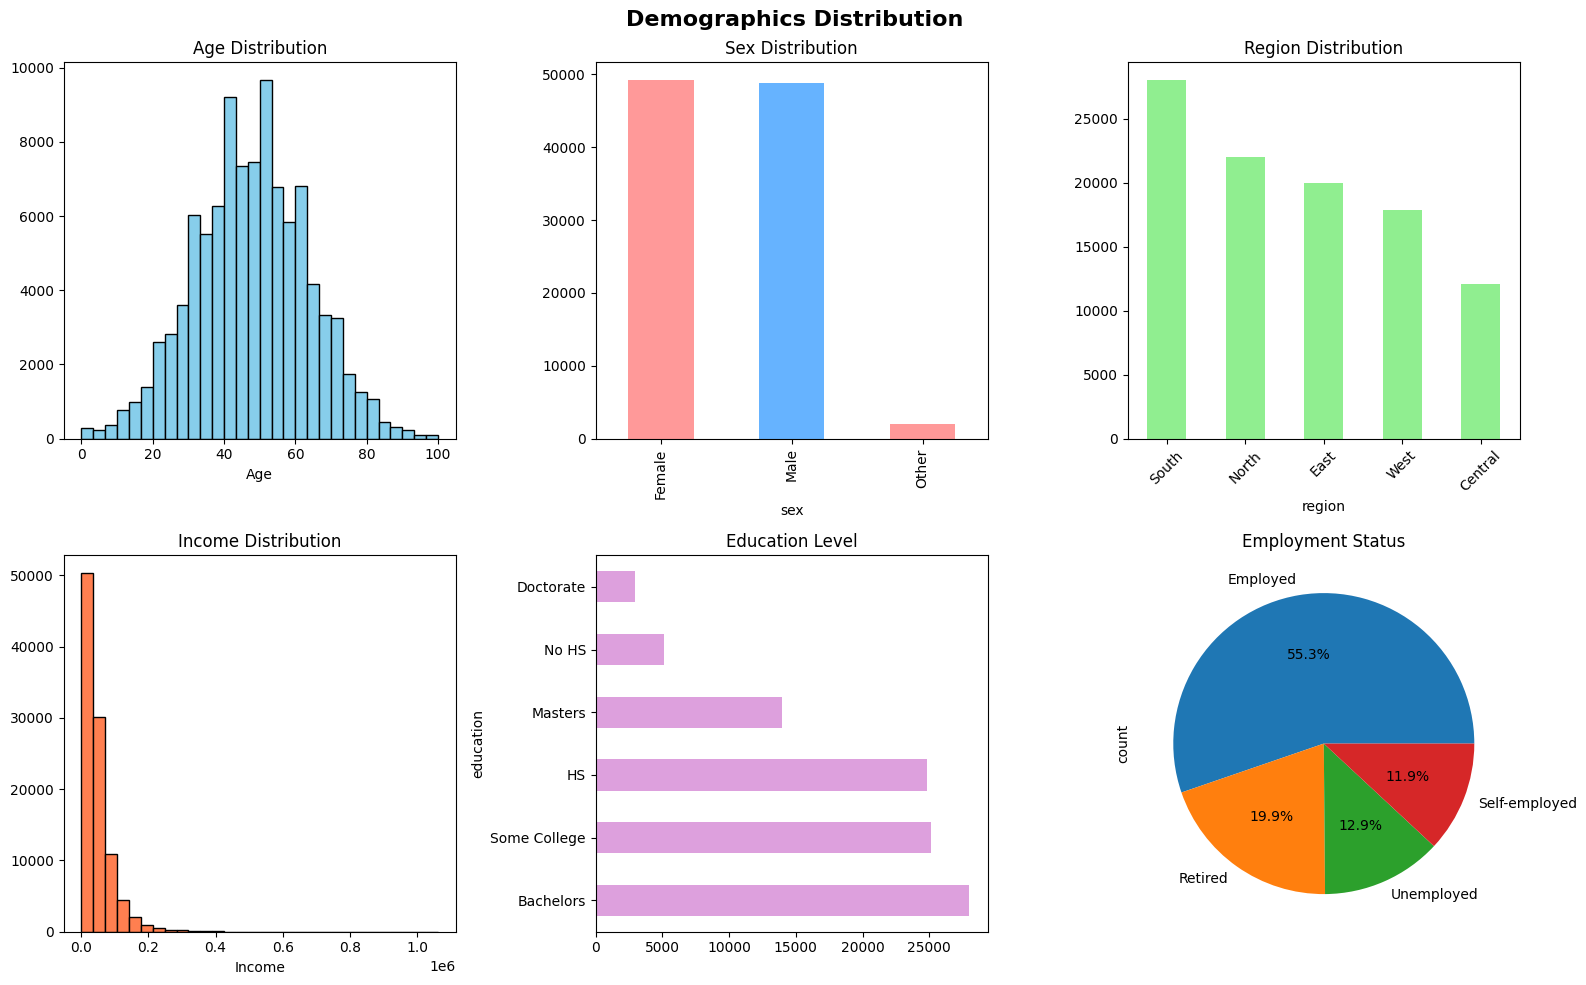

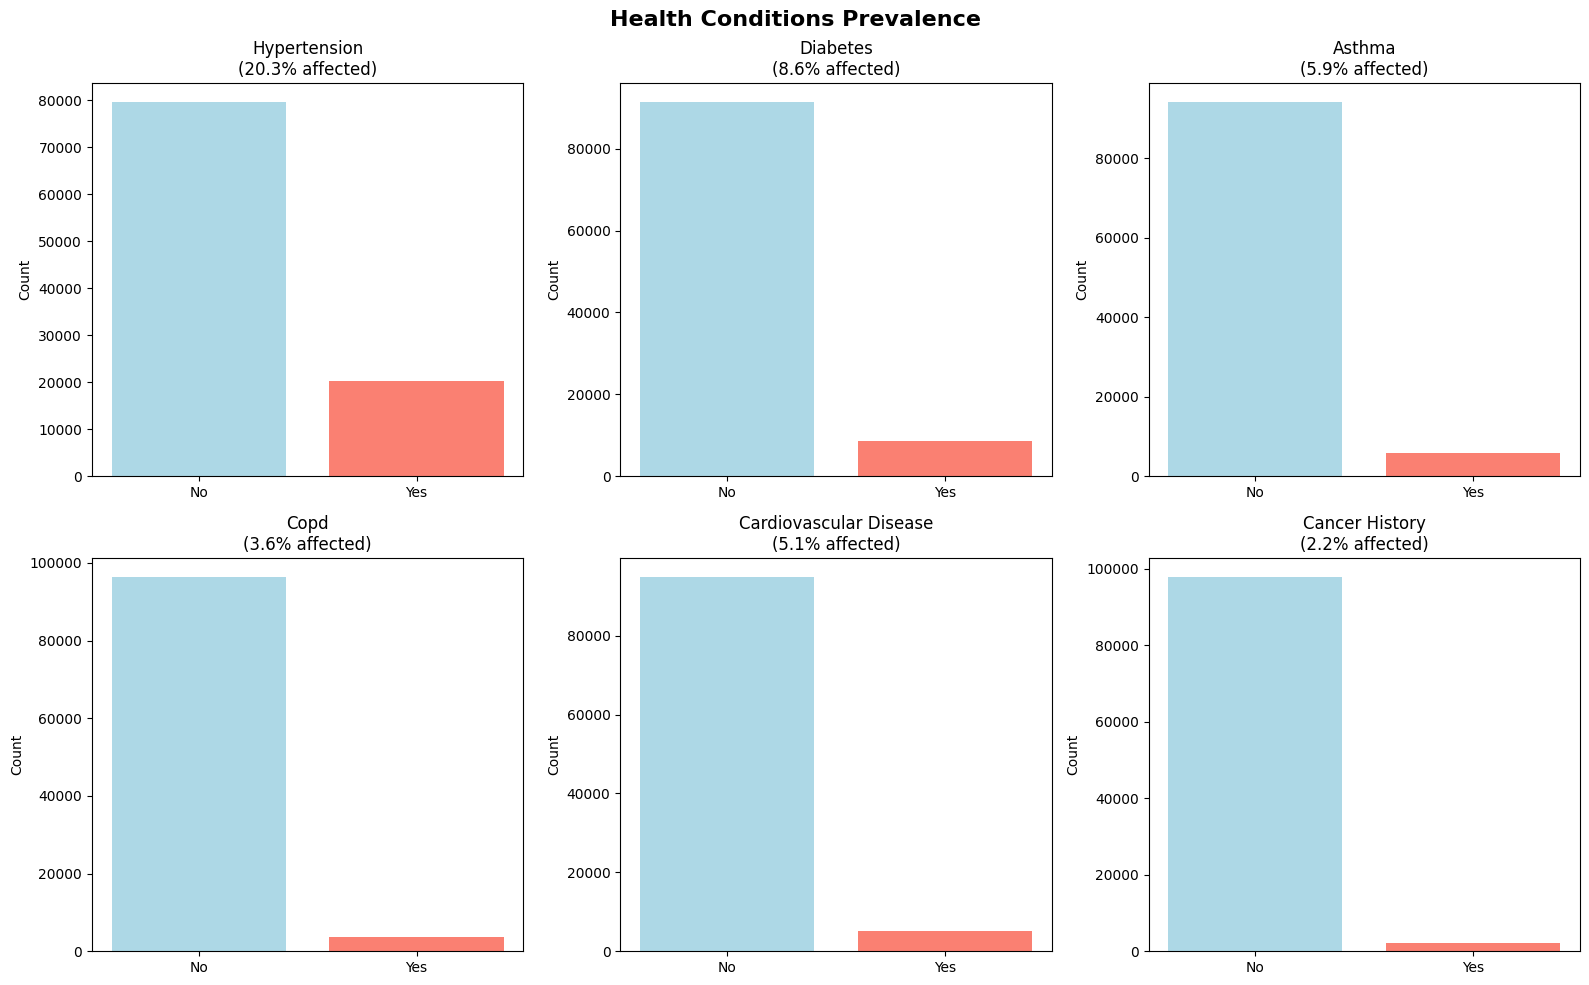

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_4556\1610503638.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1, 1].bar(['Non-Smoker', 'Smoker'], [smoker_counts.get(0, 0), smoker_counts.get(1, 0)],


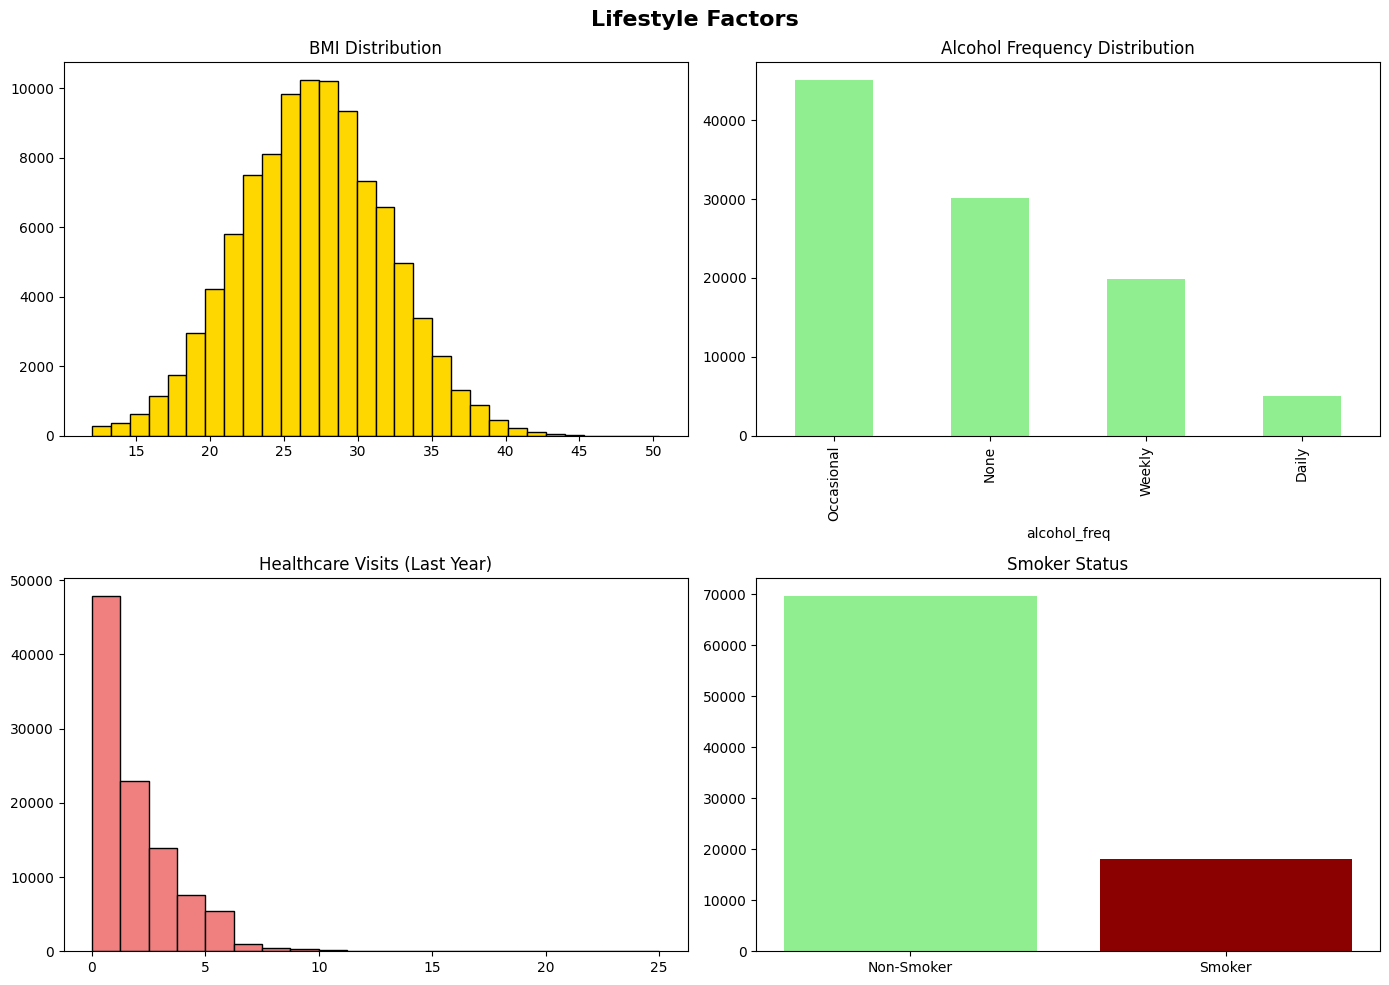

In [43]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n\n3. EXPLORATORY DATA ANALYSIS (EDA)")
print("-" * 80)

df_clean = df.toPandas()

# Demographics Distribution
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Demographics Distribution', fontsize=16, fontweight='bold')

axes[0, 0].hist(df_clean['age'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')

df_clean['sex'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['#ff9999', '#66b3ff'])
axes[0, 1].set_title('Sex Distribution')

df_clean['region'].value_counts().plot(kind='bar', ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Region Distribution')
axes[0, 2].tick_params(axis='x', rotation=45)

axes[1, 0].hist(df_clean['income'], bins=30, color='coral', edgecolor='black')
axes[1, 0].set_title('Income Distribution')
axes[1, 0].set_xlabel('Income')

df_clean['education'].value_counts().plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Education Level')

df_clean['employment_status'].value_counts().plot(kind='pie', ax=axes[1, 2], autopct='%1.1f%%')
axes[1, 2].set_title('Employment Status')

plt.tight_layout()
plt.show()

# Health Conditions
health_cols = ['hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Health Conditions Prevalence', fontsize=16, fontweight='bold')

for idx, col in enumerate(health_cols):
    ax = axes[idx // 3, idx % 3]
    counts = df_clean[col].value_counts()
    prevalence = (counts.get(1, 0) / len(df_clean) * 100) if 1 in counts.index else 0
    ax.bar(['No', 'Yes'], [counts.get(0, 0), counts.get(1, 0)], color=['lightblue', 'salmon'])
    ax.set_title(f'{col.replace("_", " ").title()}\n({prevalence:.1f}% affected)')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Lifestyle Factors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Lifestyle Factors', fontsize=16, fontweight='bold')

axes[0, 0].hist(df_clean['bmi'], bins=30, color='gold', edgecolor='black')
axes[0, 0].set_title('BMI Distribution')

# Check if alcohol_freq is numeric or categorical
if df_clean['alcohol_freq'].dtype == 'object':
    df_clean['alcohol_freq'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Alcohol Frequency Distribution')
else:
    axes[0, 1].hist(pd.to_numeric(df_clean['alcohol_freq'], errors='coerce'), bins=20, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Alcohol Frequency Distribution')

axes[1, 0].hist(df_clean['visits_last_year'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Healthcare Visits (Last Year)')

smoker_counts = df_clean['smoker'].value_counts()
axes[1, 1].bar(['Non-Smoker', 'Smoker'], [smoker_counts.get(0, 0), smoker_counts.get(1, 0)], 
               color=['lightgreen', 'darkred'])
axes[1, 1].set_title('Smoker Status')

plt.tight_layout()
plt.show()




4. MEDICAL COSTS ANALYSIS
--------------------------------------------------------------------------------
Annual Medical Cost Statistics:
  Mean: $3,009.45
  Median: $2,082.57
  Std Dev: $3,127.46
  Min: $55.55
  Max: $65,724.90


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_4556\3891826900.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1, 0].bar(['Non-Smoker', 'Smoker'], [smoker_cost.get(0, 0), smoker_cost.get(1, 0)],


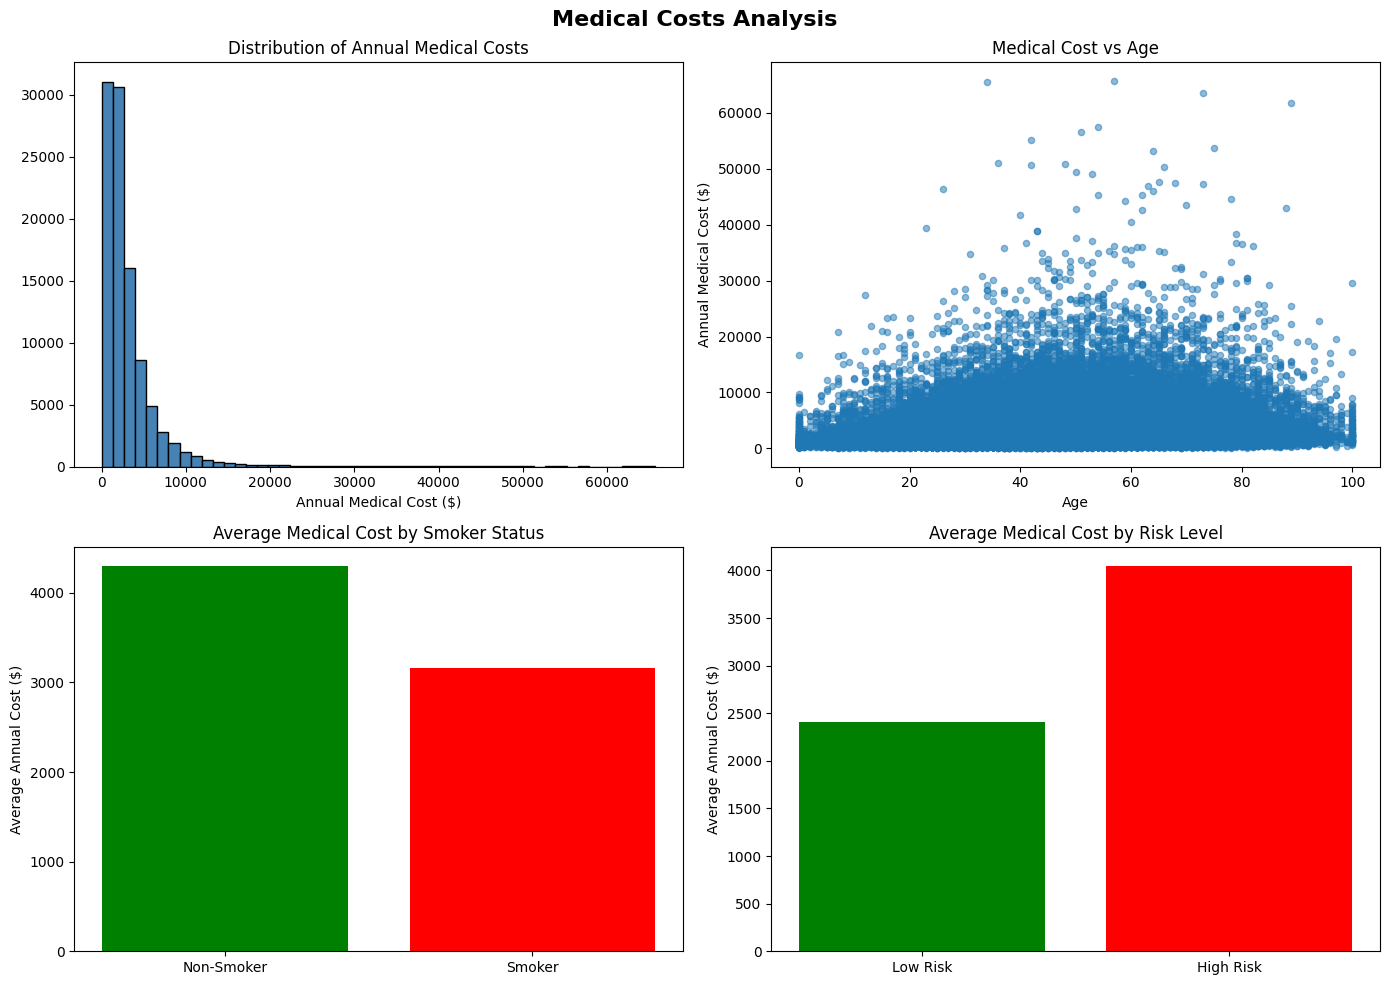

In [44]:
# ============================================================================
# 4. MEDICAL COSTS ANALYSIS
# ============================================================================
print("\n4. MEDICAL COSTS ANALYSIS")
print("-" * 80)

print(f"Annual Medical Cost Statistics:")
print(f"  Mean: ${df_clean['annual_medical_cost'].mean():,.2f}")
print(f"  Median: ${df_clean['annual_medical_cost'].median():,.2f}")
print(f"  Std Dev: ${df_clean['annual_medical_cost'].std():,.2f}")
print(f"  Min: ${df_clean['annual_medical_cost'].min():,.2f}")
print(f"  Max: ${df_clean['annual_medical_cost'].max():,.2f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Medical Costs Analysis', fontsize=16, fontweight='bold')

axes[0, 0].hist(df_clean['annual_medical_cost'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Annual Medical Costs')
axes[0, 0].set_xlabel('Annual Medical Cost ($)')

# Cost by Age
axes[0, 1].scatter(df_clean['age'], df_clean['annual_medical_cost'], alpha=0.5, s=20)
axes[0, 1].set_title('Medical Cost vs Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Annual Medical Cost ($)')

# Cost by Smoker Status
smoker_cost = df_clean.groupby('smoker')['annual_medical_cost'].mean()
axes[1, 0].bar(['Non-Smoker', 'Smoker'], [smoker_cost.get(0, 0), smoker_cost.get(1, 0)], 
               color=['green', 'red'])
axes[1, 0].set_title('Average Medical Cost by Smoker Status')
axes[1, 0].set_ylabel('Average Annual Cost ($)')

# Cost by Risk Level
risk_cost = df_clean.groupby('is_high_risk')['annual_medical_cost'].mean()
axes[1, 1].bar(['Low Risk', 'High Risk'], [risk_cost.get(0, 0), risk_cost.get(1, 0)], 
               color=['green', 'red'])
axes[1, 1].set_title('Average Medical Cost by Risk Level')
axes[1, 1].set_ylabel('Average Annual Cost ($)')

plt.tight_layout()
plt.show()


In [45]:
# ============================================================================
# 5. CORRELATION ANALYSIS
# ============================================================================
print("\n5. CORRELATION ANALYSIS")
print("-" * 80)

numeric_cols = [c for c, t in df.dtypes if t in ("double", "int")]

corr_results = []
for col in numeric_cols:
    if col != "annual_medical_cost":
        corr_val = df.stat.corr("annual_medical_cost", col)
        if corr_val is not None:
            corr_results.append((col, round(corr_val, 3)))

# Urutkan berdasarkan korelasi absolut
corr_sorted = sorted(corr_results, key=lambda x: abs(x[1]), reverse=True)

print("Top 15 Features Correlated with Annual Medical Cost:")
for col_name, corr in corr_sorted[:15]:
    print(f"{col_name}: {corr}")



5. CORRELATION ANALYSIS
--------------------------------------------------------------------------------
Top 15 Features Correlated with Annual Medical Cost:
annual_premium: 0.965
monthly_premium: 0.965
total_claims_paid: 0.739
avg_claim_amount: 0.633
risk_score: 0.306
chronic_count: 0.297
is_high_risk: 0.252
days_hospitalized_last_3yrs: 0.23
hospitalizations_last_3yrs: 0.209
visits_last_year: 0.196
claims_count: 0.179
hypertension: 0.154
had_major_procedure: 0.148
systolic_bp: 0.145
age: 0.131


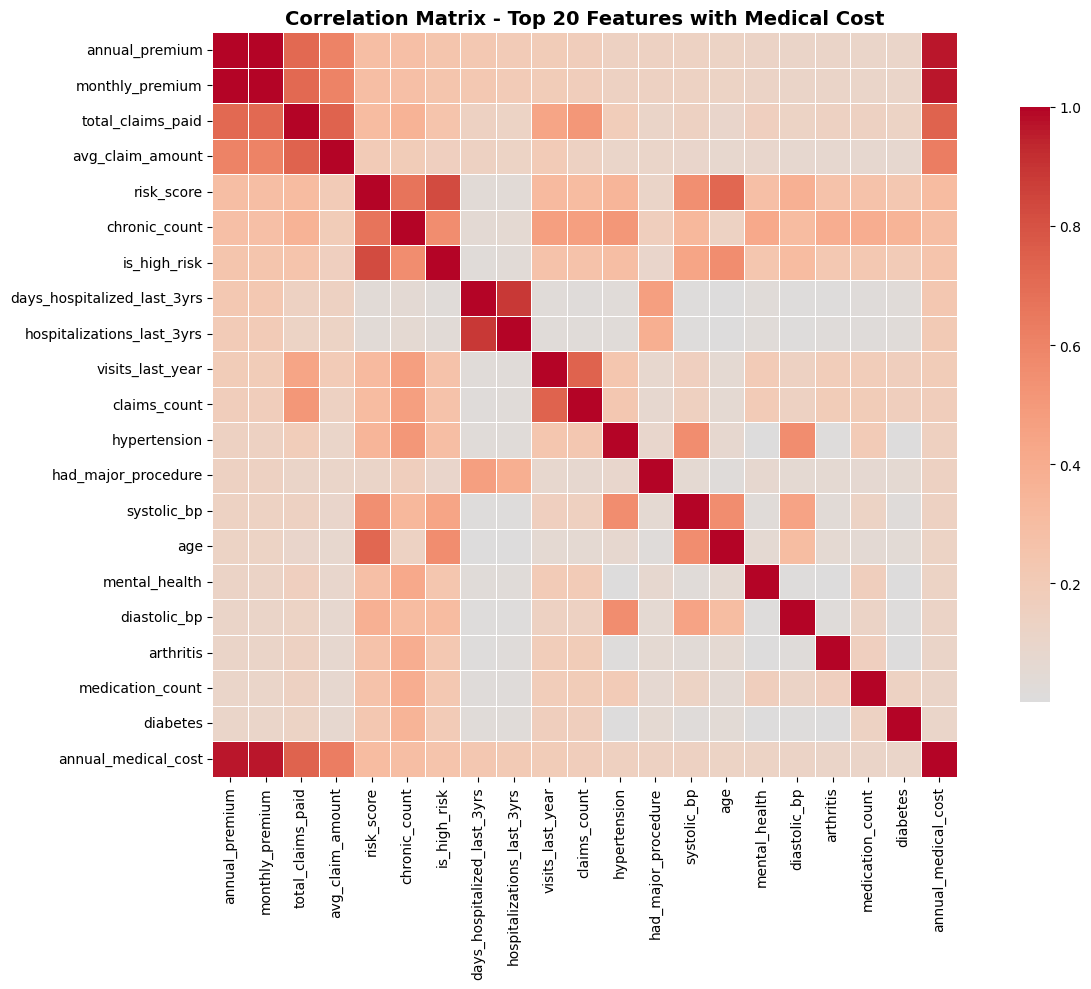

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil 20 fitur dengan korelasi tertinggi
top_features = [col for col, _ in corr_sorted[:20]] + ["annual_medical_cost"]

# Konversi ke Pandas
df_pd = df.select(top_features).toPandas()

# Hitung matriks korelasi
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 20 Features with Medical Cost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [47]:
# ============================================================================
# 6. DATA TRANSFORMATION FOR MODELING
# ============================================================================
print("\n\n2. DATA TRANSFORMATION FOR MODELING")
print("-" * 80)

# Siapkan data untuk modeling

# Kolom yang akan di-drop (kecuali person_id karena nanti untuk join kembali)
features_to_drop = ['annual_medical_cost', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'total_claims_paid']
# df_target = df.select("annual_medical_cost")
df_target = df.select("person_id", "annual_medical_cost")

df = df.drop(*features_to_drop)

# Identifikasi kolom kategorikal dan numerik
categorical_cols = [c for c, t in df.dtypes if t == 'string']
numeric_cols = [c for c, t in df.dtypes if t in ('double', 'int')]

df_target.show(5)



2. DATA TRANSFORMATION FOR MODELING
--------------------------------------------------------------------------------
+---------+-------------------+
|person_id|annual_medical_cost|
+---------+-------------------+
|    75722|            6938.06|
|    80185|            1632.61|
|    19865|            7661.01|
|    76700|            5130.27|
|    92992|            1700.73|
+---------+-------------------+
only showing top 5 rows


In [48]:
# Encode Fitur Kategorikal
# StringIndexer untuk setiap kolom kategorikal
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in categorical_cols]

# OneHotEncoder untuk hasil index
encoder = OneHotEncoder(
    inputCols=[f"{c}_indexed" for c in categorical_cols],
    outputCols=[f"{c}_encoded" for c in categorical_cols]
)

In [49]:
# Gabungkan semua fitur numerik dan hasil encoding
final_features = numeric_cols + [f"{c}_encoded" for c in categorical_cols]

assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features"
)

In [50]:
# Normalisasi untu menyeragamkan skala
# scaler = StandardScaler(
#     inputCol="features",
#     outputCol="scaled_features",
#     withMean=True,
#     withStd=True
# )
# Karena hanya linear regression yang sensitif terhadap skala, maka tidak perlu dinormalisasi

In [51]:
# Lanjutkan preprocessing pipeline dan transformasi data
# pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler])
pipeline = Pipeline(stages=indexers + [encoder, assembler])
df_preprocessed = pipeline.fit(df).transform(df)

In [52]:
# Gabungkan kembali kolom target
df_preprocessed = df_preprocessed.join(df_target, on="person_id", how="inner")
df_preprocessed.select("features", "annual_medical_cost").show(5)

+--------------------+-------------------+
|            features|annual_medical_cost|
+--------------------+-------------------+
|(79,[0,1,2,3,4,5,...|            6938.06|
|(79,[0,1,2,3,4,5,...|            1632.61|
|(79,[0,1,2,3,4,5,...|            7661.01|
|(79,[0,1,2,3,4,5,...|            5130.27|
|(79,[0,1,2,3,5,6,...|            1700.73|
+--------------------+-------------------+
only showing top 5 rows


In [ ]:
# Ambil metadata dari kolom 'features'
attrs = df_preprocessed.schema["features"].metadata["ml_attr"]["attrs"]

# Pisahkan fitur berdasarkan kategori
numeric_features = attrs.get("numeric", [])
categorical_features = attrs.get("binary", [])  # hasil OneHotEncoder biasanya masuk ke 'binary'

# Gabungkan semua nama fitur
feature_names = [attr["name"] for group in attrs.values() for attr in group]

# Buat DataFrame daftar fitur
df_features_list = pd.DataFrame({
    "No": range(1, len(feature_names) + 1),
    "Fitur": feature_names
})

# Tampilkan daftar fitur secara inline
print("Fitur yang akan digunakan dalam modeling:\n")
# # display(df_features_list)
print(df_features_list.to_string(index=False))


# Tampilkan jumlah masing-masing kategori fitur
print("\nRingkasan jumlah fitur berdasarkan jenis:")
print(f"- Fitur numerik       : {len(numeric_features)}")
print(f"- Fitur kategorikal   : {len(categorical_features)}")
print(f"- Total fitur gabungan: {len(feature_names)}")

Fitur yang akan digunakan dalam modeling:

 No                                   Fitur
  1                      sex_encoded_Female
  2                        sex_encoded_Male
  3                       sex_encoded_Other
  4                    region_encoded_South
  5                    region_encoded_North
  6                     region_encoded_East
  7                     region_encoded_West
  8                  region_encoded_Central
  9               urban_rural_encoded_Urban
 10            urban_rural_encoded_Suburban
 11               urban_rural_encoded_Rural
 12             education_encoded_Bachelors
 13          education_encoded_Some College
 14                    education_encoded_HS
 15               education_encoded_Masters
 16                 education_encoded_No HS
 17             education_encoded_Doctorate
 18          marital_status_encoded_Married
 19           marital_status_encoded_Single
 20         marital_status_encoded_Divorced
 21          marital_status_encod

In [54]:
# Simpan hasil preprocessing ke format Parquet (lebih aman untuk tipe data Spark)
output_path = "../data/processed/processed_medical_cost.parquet"

# Hapus folder lama jika ada (opsional)
if os.path.exists(output_path):
    shutil.rmtree(output_path)

df_preprocessed.write.mode("overwrite").parquet(output_path)

print("Data berhasil disimpan ke:", output_path)

Data berhasil disimpan ke: ../data/processed/processed_medical_cost.parquet
